In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

key = os.getenv("KOSIS_API_KEY")


In [2]:
import json
import re


def parse_kosis_loose(text: str):
    """
    KOSIS에서 내려오는 [{OBJ_ID:"A", ...}] 형태(키 따옴표 없음)를
    JSON으로 보정해서 list[dict]로 변환
    """
    t = text.strip()

    # {KEY: 또는 ,KEY: 를 {"KEY": 로 변환
    t = re.sub(r"([{,]\s*)([A-Za-z0-9_]+)\s*:", r'\1"\2":', t)

    # 혹시 값이 '...'로 오는 경우까지 대비(현재는 "..."라 그대로 OK)
    t = t.replace("'", '"')

    return json.loads(t)


In [4]:
import pandas as pd
import requests as req

import lib.util as u

base_url = "https://kosis.kr/openapi/statisticsData.do"

params = {
    "method": "getMeta",
    "type": "ITM",
    "apiKey": key,
    "orgId": "101",
    "tblId": "DT_1YL20642",
    "format": "json",
    "jsonVD": "Y",
}

res = req.get(base_url, params=params)

print(res.status_code)

res_text = res.text

print(res_text)

rows = u.parse_kosis_loose(res_text)
df = pd.DataFrame(rows)
# df.to_csv("../../data/item_code.csv")

200
[{"OBJ_NM_ENG":"Item code list","ITM_ID":"T001","TBL_ID":"DT_1YL20642","OBJ_NM":"항목","ITM_NM":"청년순이동률","ORG_ID":"101","OBJ_ID":"ITEM"},{"ITM_ID":"00","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"전국","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"ITM_ID":"11","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"서울특별시","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11010","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"종로구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11020","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"중구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11030","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"용산구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11040","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"성동구","ORG_ID":"101","OBJ_ID_SN":"1","OBJ_ID":"A"},{"UP_ITM_ID":"11","ITM_ID":"11050","TBL_ID":"DT_1YL20642","OBJ_NM":"행정구역별","ITM_NM":"광진구","

In [5]:
import requests as req

url = "https://kosis.kr/openapi/Param/statisticsParameterData.do"
params = {
    "method": "getList",
    "apiKey": key,
    "orgId": "101",
    "tblId": "DT_1YL20642",
    "itmId": "T001",
    "objL1": "ALL",
    "objL2": "ALL",  # 필수
    "prdSe": "Y",
    "newEstPrdCnt": "3",
    "format": "json",
    "jsonVD": "Y",  # 이거 안넣으면 json 형태로 안옴
}

res = req.get(url, params=params)
print(res.status_code)
print(res.text[:300])


200
[{"C1_OBJ_NM":"행정구역별","C2_NM":"청년순이동률(19~39세)","DT":"0","C2":"11","C1":"00","PRD_SE":"A","UNIT_NM_ENG":"%","ITM_ID":"T001","TBL_ID":"DT_1YL20642","ITM_NM":"청년순이동률","TBL_NM":"청년순이동률(시도/시/군/구)","PRD_DE":"2022","LST_CHN_DE":"2024-10-08","C1_NM":"전국","UNIT_NM":"%","ORG_ID":"101","C2_OBJ_NM":"청년순이동률 지표"}


In [6]:
import pandas as pd

df = pd.DataFrame(res.json())
# df.head()

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4428 entries, 0 to 4427
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   C1_OBJ_NM    4428 non-null   object
 1   C2_NM        4428 non-null   object
 2   DT           4428 non-null   object
 3   C2           4428 non-null   object
 4   C1           4428 non-null   object
 5   PRD_SE       4428 non-null   object
 6   UNIT_NM_ENG  4428 non-null   object
 7   ITM_ID       4428 non-null   object
 8   TBL_ID       4428 non-null   object
 9   ITM_NM       4428 non-null   object
 10  TBL_NM       4428 non-null   object
 11  PRD_DE       4428 non-null   object
 12  LST_CHN_DE   4428 non-null   object
 13  C1_NM        4428 non-null   object
 14  UNIT_NM      4428 non-null   object
 15  ORG_ID       4428 non-null   object
 16  C2_OBJ_NM    4428 non-null   object
dtypes: object(17)
memory usage: 588.2+ KB


,C1_OBJ_NM,C2_NM,DT,C2,C1,PRD_SE,UNIT_NM_ENG,ITM_ID,TBL_ID,ITM_NM,TBL_NM,PRD_DE,LST_CHN_DE,C1_NM,UNIT_NM,ORG_ID,C2_OBJ_NM
count,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
unique,1,6,2803,6,247,1,2,1,1,1,1,3,2,224,2,1,1
top,행정구역별,청년순이동률(19~39세),0,11,00,A,In person,T001,DT_1YL20642,청년순이동률,청년순이동률(시도/시/군/구),2022,2024-10-08,중구,명,101,청년순이동률 지표
freq,4428,738,36,738,18,4428,2952,4428,4428,4428,4428,1476,2952,108,2952,4428,4428


In [ ]:
df

In [ ]:
# 1. 데이터 타입 정리
df["DT"] = pd.to_numeric(df["DT"], errors="coerce")
df["PRD_DE"] = df["PRD_DE"].astype(str)

# 2. 청년순이동률만 선택
df = df[df["C2"] == "11"]

# 3. 수도권 + 광역시 제거
exclude_codes = [
    "11",
    "23",
    "31",  # 수도권
    "21",
    "22",
    "24",
    "25",
    "26",  # 광역시
]

df = df[~df["C1"].astype(str).isin(exclude_codes)]

# 4. 최신연도 TOP5
latest_year = df["PRD_DE"].max()

top_5 = (
    df[df["PRD_DE"] == latest_year][["C1_NM", "DT"]]
    .rename(columns={"C1_NM": "지역", "DT": "청년순이동률"})
    .sort_values("청년순이동률", ascending=False)
    .head()
)

print("⭐ 최신연도:", latest_year)
print(top_5)

       지역  청년순이동률
812    중구    14.0
1976  양주시    11.7
986    중구     8.5
1706  과천시     7.9
1760  오산시     7.8
⭐ 최신연도: 2024
       지역  청년순이동률     지역표시
812    중구    14.0   중구(22)
1976  양주시    11.7  양주시(31)
986    중구     8.5   중구(23)
1706  과천시     7.9  과천시(31)
1760  오산시     7.8  오산시(31)


In [12]:
sido_map = {
    "11": "서울",
    "21": "부산",
    "22": "대구",
    "23": "인천",
    "24": "광주",
    "25": "대전",
    "26": "울산",
    "29": "세종",
    "31": "경기",
    "32": "강원",
    "33": "충북",
    "34": "충남",
    "35": "전북",
    "36": "전남",
    "37": "경북",
    "38": "경남",
    "39": "제주",
}

top_5["시도"] = df["C1"].astype(str).str[:2].map(sido_map)
top_5["지역표시"] = top_5["시도"] + " " + top_5["지역"]

top_5

,지역,청년순이동률,지역표시,시도
812,중구,14.0,대구 중구,대구
1976,양주시,11.7,경기 양주시,경기
986,중구,8.5,인천 중구,인천
1706,과천시,7.9,경기 과천시,경기
1760,오산시,7.8,경기 오산시,경기


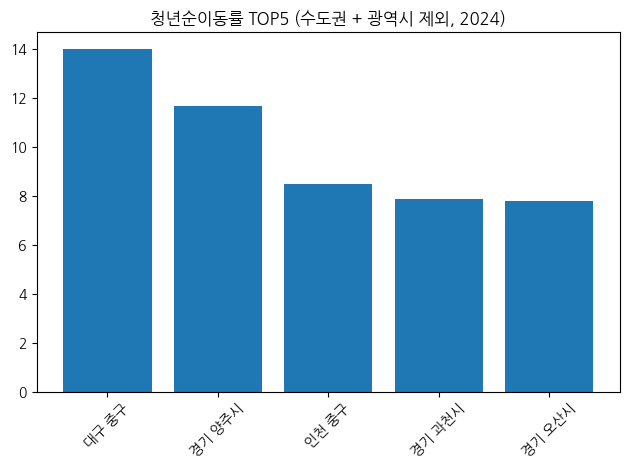

In [ ]:
import koreanize_matplotlib  # noqa: F401
import matplotlib.pyplot as plt

plt.figure()
plt.bar(top_5["지역표시"], top_5["청년순이동률"])
plt.title(f"청년순이동률 TOP5 (수도권 + 광역시 제외, {latest_year})")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()